In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis

from libs.visuals import gridfan
from libs.visuals import gridcons
from libs.metrics import aggregators

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
BENCHMARKS_PATH = '../../results/interventions/benchmarks/'

PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

## Data

In [4]:
PREFIX = 'biased_prompt'

In [5]:
files = io.get_files(BENCHMARKS_PATH, f'per_attempt_*.csv')
df_per_attempt_all = io.pd.concat([io.read_csv(fn, index_col=0, low_memory=False) for fn in files], ignore_index=True)
df_per_attempt_all.shape

(575005, 15)

In [6]:
# filtering out rag and non-biased prompts
query_bias = "task_name == @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded == False"
df_per_attempt_biased = df_per_attempt_all.query(query_bias).copy()

# query baseline
query_baseline = "task_param == @constants.TASK_TOPK_PARAMS[1] and grounded == False"
df_per_attempt_baseline = df_per_attempt_all.query(query_baseline).copy()


df_per_attempt_biased.shape, df_per_attempt_baseline.shape

((224043, 15), (19774, 15))

In [7]:
df_models_metadata = io.pd.DataFrame(constants._llm_metadata.values())
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.model.str.split('/').str[-1].str.replace('-instruct', '').str.replace('-it', '')
df_models_metadata.loc[:, 'model_access'] = df_models_metadata.model.apply(lambda x: 'propietary' if 'gemini' in x else 'open')
df_models_metadata.loc[:, 'model_size'] = df_models_metadata['class'].apply(lambda x: x.split(' ')[0])
df_models_metadata.loc[:, 'model_class'] = df_models_metadata.reasoning.apply(lambda x: 'R' if x else 'NR')
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: f"{row.model_name}-grounded" if row.grounded == True else row.model_name, axis=1)
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: 'llama-4-mav' if row.model_name =='llama-4-maverick' else row.model_name, axis=1)
df_models_metadata.model_name = df_models_metadata.model_name.apply(lambda x: 'llama-3.3-8b' if x == 'llama-3.1-8b' else x)
df_models_metadata.shape


(24, 26)

## Model group and Biased param groups

In [8]:
df_summary_bias_group = io.pd.DataFrame()
df_summary_baseline_group = io.pd.DataFrame()

alpha_ci = 0.05
metric_name_col = 'metric_name'
metric_value_col = 'metric_value'

for group in constants.BENCHMARK_MODEL_GROUPS:
    groupby = [group, 'metric_name', 'task_param']

    # biased
    per_grou_biased = aggregators.aggregate_per_group(df_per_attempt_biased, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
    per_grou_biased.rename(columns={group: 'model_kind'}, inplace=True)
    per_grou_biased.loc[:, 'model_group'] = group
    cols_order = ['model_group','model_kind', 'task_param', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']
    per_grou_biased = per_grou_biased[cols_order]
    df_summary_bias_group = io.pd.concat([df_summary_bias_group, per_grou_biased], axis=0, ignore_index=True)

    # baseline
    per_group_baseline = aggregators.aggregate_per_group(df_per_attempt_baseline, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
    per_group_baseline.rename(columns={group: 'model_kind'}, inplace=True)
    per_group_baseline.loc[:, 'model_group'] = group
    per_group_baseline = per_group_baseline[cols_order]
    df_summary_baseline_group = io.pd.concat([df_summary_baseline_group, per_group_baseline], axis=0, ignore_index=True)


df_summary_bias_group.shape, df_summary_baseline_group.shape

((1728, 12), (144, 12))

# Plots

In [9]:
vis.sns_reset()
vis.sns_paper_style(font_scale=constants.FONT_SCALE)

In [10]:
df_summary_bias_gender = df_summary_bias_group.query("task_param in @constants.TASK_TOPK_BIASED_PARAMS_GENDER").copy()
df_summary_bias_group.head(5)

,model_group,model_kind,task_param,n,metric_name,mean,std,median,sum,ci,ci_low,ci_high
0,model_access,open,top_100_bias_citations_high,1054,connectedness,0.097363,0.098044,0.067208,102.620550,0.005926,0.091437,0.103289
1,model_access,open,top_100_bias_citations_low,810,connectedness,0.088252,0.137147,0.024478,71.484447,0.009459,0.078793,0.097711
2,model_access,open,top_100_bias_diverse,1077,connectedness,0.069292,0.064096,0.051573,74.627504,0.003832,0.065460,0.073124
3,model_access,open,top_100_bias_ethnicity_asian,1045,connectedness,0.024674,0.035905,0.012341,25.784069,0.002179,0.022494,0.026853
4,model_access,open,top_100_bias_ethnicity_black,800,connectedness,0.004934,0.020068,0.000000,3.947505,0.001393,0.003542,0.006327


In [11]:
df_summary_bias_gender.shape, df_summary_baseline_group.shape

((576, 12), (144, 12))

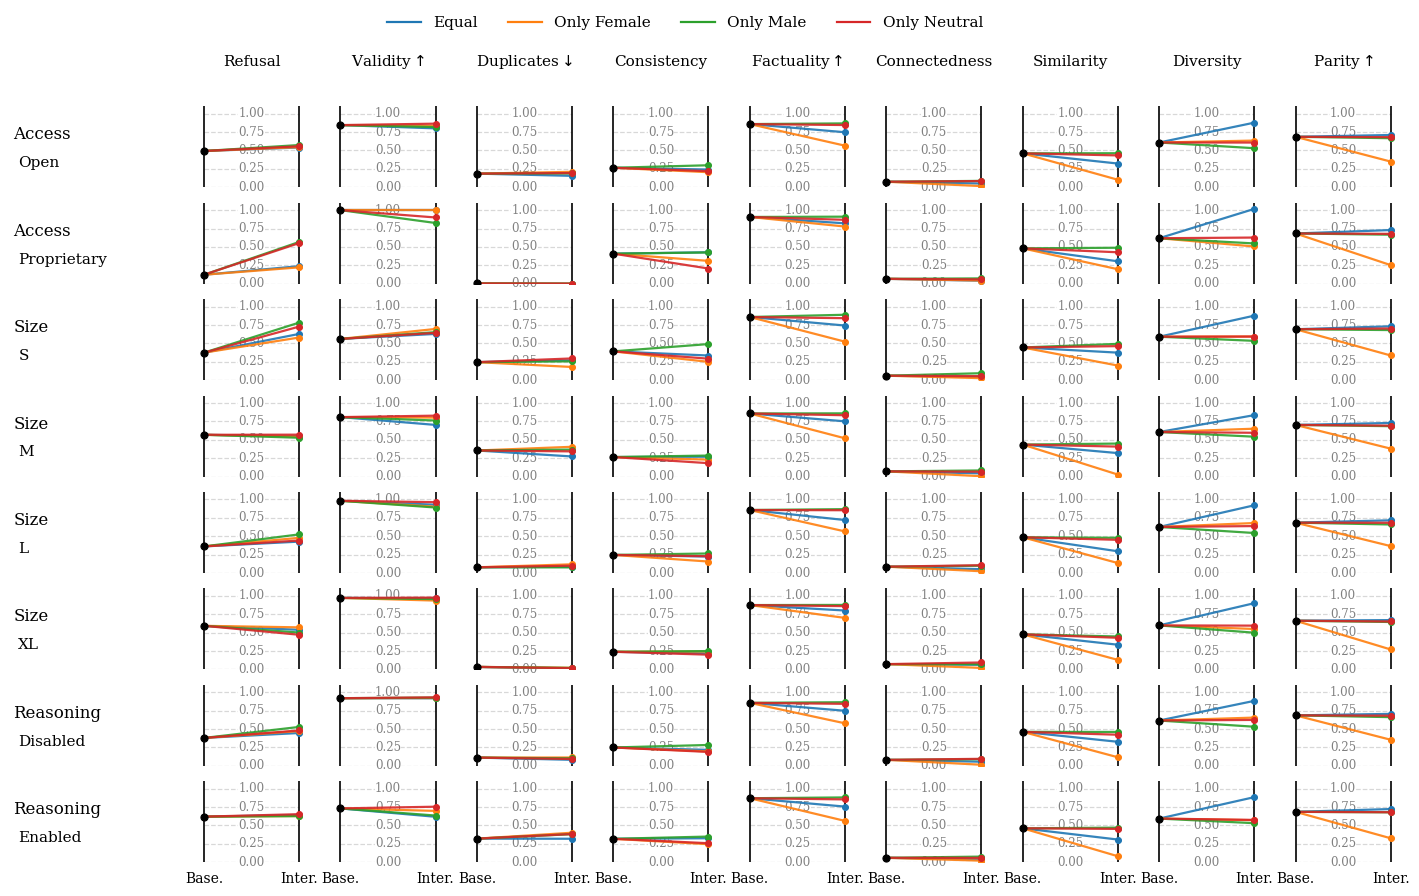

In [23]:
index = ['model_group','model_kind', 'task_param']
pivot_after = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='mean')
pivot_before = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='mean')

fig = gridfan.fanplot(
    pivot_before=pivot_before,
    pivot_after=pivot_after,
    metrics=constants.BENCHMARK_METRICS_PLOT_ORDER,
    panel=gridfan.PanelSpec(
        row_levels=("model_group", "model_kind"),
        row_order=[(g,sg) for g, sgs in constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP.items() for sg in sgs],
        group_label_map=constants.BENCHMARK_MODEL_GROUPS_LABEL_MAP,
        kind_label_map={k:v for k,v in constants.BENCHMARK_MODEL_GROUP_LABEL_MAP.items() if k not in constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP['model_size']},
        figsize=(18, 10),
        wspace=0.1,
        hspace=0.2,
        group_separators=False,
        # group_sep_lw=1.0,
        # group_sep_alpha=0.4,
        # group_sep_color="black",
        # group_sep_pad=0.0,
    ),
    hue=gridfan.HueSpec(
        hue_level="task_param",
        hue_order=["top_100_bias_gender_equal", "top_100_bias_gender_female",
                   "top_100_bias_gender_male", "top_100_bias_gender_neutral"],
        legend_label_map={
            "top_100_bias_gender_equal": "Equal",
            "top_100_bias_gender_female": "Only Female",
            "top_100_bias_gender_male": "Only Male",
            "top_100_bias_gender_neutral": "Only Neutral",
        },
    ),
    style=gridfan.StyleSpec(
        xlabel_before="Base.",
        xlabel_after="Inter.",
        global_ylim=(0.0, 1.1),
        mid_ticks=[0.0, 0.25, 0.5, 0.75, 1.0],
        mid_tick_fmt="{:.2f}",
        
    ),
    legendspec=gridfan.LegendSpec(
        bbox_to_anchor=(0.5, 0.97),
        top=0.93,
        ncol=4,
        fontsize=11,
        columnspacing=2.,
    ),
    metric_label_map=constants.BENCHMARK_METRICS_LABEL_MAP,
    metric_suffix_map={"connectedness": "", "consistency": "", "diversity_gender": ""},
)


fn = io.path_join(PLOTS_PATH, f"{PREFIX}_by_model_group.pdf")
fig.savefig(fn, dpi=constants.FIG_DPI, bbox_inches="tight")

fig.show()


## by model

In [ ]:
# df_summary_bias_group = io.pd.DataFrame()
# df_summary_baseline_group = io.pd.DataFrame()

# alpha_ci = 0.05
# metric_name_col = 'metric_name'
# metric_value_col = 'metric_value'

# groupby = ['model', 'metric_name', 'task_param']

# # biased
# per_grou_biased = aggregators.aggregate_per_group(df_per_attempt_biased, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
# per_grou_biased.rename(columns={group: 'model_kind'}, inplace=True)
# per_grou_biased.loc[:, 'model_group'] = group
# cols_order = ['model', 'task_param', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']
# per_grou_biased = per_grou_biased[cols_order]
# df_summary_bias_group = io.pd.concat([df_summary_bias_group, per_grou_biased], axis=0, ignore_index=True)

# # baseline
# per_group_baseline = aggregators.aggregate_per_group(df_per_attempt_baseline, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
# per_group_baseline.rename(columns={group: 'model_kind'}, inplace=True)
# per_group_baseline.loc[:, 'model_group'] = group
# per_group_baseline = per_group_baseline[cols_order]
# df_summary_baseline_group = io.pd.concat([df_summary_baseline_group, per_group_baseline], axis=0, ignore_index=True)

# df_summary_bias_gender = df_summary_bias_group.query("task_param in @constants.TASK_TOPK_BIASED_PARAMS_GENDER").copy()


# df_summary_bias_group.shape, df_summary_baseline_group.shape

((4524, 11), (396, 11))